In [40]:
import numpy as np
from typing import Callable
import vrplib
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
from collections import defaultdict
from os import walk
import time
from dataclasses import dataclass
import pickle

## Sequential heuristic
Эривстика для получения начального решения

In [42]:
def sequential_heuristic(n, Q, m, distances, demands, depot):
    def get_faraway_unvuser():
        max_user = -1
        max_dist = 0
        
        for u in range(n):
            if not visited[u] and distances[depot][u] > max_dist:
                max_dist = distances[depot][u]
                max_user = u
        return max_user
        
    def get_closest_unvuser(u_init: int):
        cu = -1
        min_dist = float('inf')
        
        for u in range(n):
            if not visited[u] and distances[u_init][u] < min_dist:
                min_dist = distances[u_init][u]
                cu = u
        return cu
        
    
    visited = np.zeros(n, dtype=bool)
    visited[depot] = True
    
    # Solution
    x = []
    
    while not all(visited):
        cur_route = []
        
        # Initialize new route by faraway unvisited user
        cur_Q = 0
        init_user = get_faraway_unvuser()
        
        # Visit
        cur_Q += demands[init_user]
        cur_route.append(init_user)
        visited[init_user] = True
        
        while True:
            # Get the closest unvisited
            last_user = cur_route[-1]
            closest_user = get_closest_unvuser(last_user)
            
            # No user found
            if closest_user == -1:
                break
            
            # If capacity exceeds
            if cur_Q + demands[closest_user] > Q:
                break
            
            # Visit
            cur_Q += demands[closest_user]
            cur_route.append(closest_user)
            visited[closest_user] = True
        
        # Add current route
        x.append(cur_route)
        
    
    while len(x) < m:
        x.append([])
    
    return x

## Вспомогательные функции

In [43]:
def is_valid(route, demands, Q):
    return np.sum(demands[route]) <= Q

In [44]:
def get_nearest(route, last_u, distances):
    best_u = route[0]
    for u in route:
        if distances[last_u][u] < distances[last_u][best_u]:
            best_u = u
    return best_u
    
    
def get_nearest_unvisited(route, last_u, distances, visited):
    best_u = -1
    best_dist = float('inf')
    
    for u in route:
        if distances[last_u][u] < best_dist and u not in visited:
            best_u = u
            best_dist = distances[last_u][u]
    return best_u


def rearange_route(near_solution, r_idx, distances, depot):
    part1, part2 = [], []
    old_route = near_solution[r_idx]
    visited = set()

    end1 = depot
    end2 = depot
    while len(visited) < len(old_route):
        u1 = get_nearest_unvisited(old_route, end1, distances, visited)
        visited.add(u1)
        part1.append(u1)

        u2 = get_nearest_unvisited(old_route, end2, distances, visited)
        visited.add(u2)

        if u1 != u2 and u2 != -1:
            part2.append(u2)

        end1 = u1
        end2 = u2

    new_route = part1 + part2[::-1]
    old_obj = objective([old_route], distances, depot)
    new_obj = objective([new_route], distances, depot)

    if new_obj < old_obj:
        near_solution[r_idx] = new_route


def rearange_route_old(near_solution, r_idx, distances, depot):
    old_route = near_solution[r_idx]
    visited = set()
    
    new_route = []
    last_u = depot
    while len(visited) < len(old_route):
        u = get_nearest_unvisited(old_route, last_u, distances, visited)
        visited.add(u)
        new_route.append(u)
        last_u = u
        
    old_obj = objective([old_route], distances, depot)
    new_obj = objective([new_route], distances, depot)

    if new_obj < old_obj:
        near_solution[r_idx] = new_route
        

def get_near_solution(current_solution: list, demands, Q, m, distances, depot, num_steps):    
    """
        Randomly choose num_steps times between:
             1) Swap two random users between two random routes
             2) Swap two random users within a random route
             3) Move random user from one random route to another
         Reroute. 
    """
    near_solution = copy.deepcopy(current_solution)
    border1 = 1.0 / 3.0
    border2 = 2.0 / 3.0
    
    can_delete_route = True if len(near_solution) > m else False
    
    for _ in range(num_steps):
        rand_num = np.random.rand()
        
        if can_delete_route:
            for i in range(len(near_solution) - 1, -1, -1):
                if len(near_solution[i]) == 0:
                    near_solution.pop(i)
        
        # Swap random users between two random routes
        if rand_num < border1:
            r1_idx, r2_idx = np.random.choice(len(near_solution), size=2, replace=False) 
            
            u1_idx = np.random.randint(len(near_solution[r1_idx]))
            u2_idx = np.random.randint(len(near_solution[r2_idx]))

            u1 = near_solution[r1_idx].pop(u1_idx)
            u2 = near_solution[r2_idx].pop(u2_idx)

            near_solution[r1_idx].insert(u1_idx, u2)
            near_solution[r2_idx].insert(u2_idx, u1)

            if not is_valid(near_solution[r1_idx], demands, Q) or not is_valid(near_solution[r2_idx], demands, Q):
                near_solution[r1_idx].pop(u1_idx)
                near_solution[r1_idx].insert(u1_idx, u1)

                near_solution[r2_idx].pop(u2_idx)
                near_solution[r2_idx].insert(u2_idx, u2)
            else:
                rearange_route(near_solution, r1_idx, distances, depot)
                rearange_route(near_solution, r2_idx, distances, depot)
                
                rearange_route_old(near_solution, r1_idx, distances, depot)
                rearange_route_old(near_solution, r2_idx, distances, depot)
        
        # Swap two random users within a random route
        elif rand_num < border2:
            r_idx = np.random.choice(len(near_solution))
            while len(near_solution[r_idx]) < 2:
                r_idx += 1
                r_idx %= len(near_solution)
            
            u1_idx, u2_idx = np.random.choice(len(near_solution[r_idx]), size=2, replace=False)
            near_solution[r_idx][u1_idx], near_solution[r_idx][u2_idx] = \
                        near_solution[r_idx][u2_idx], near_solution[r_idx][u1_idx]
            rearange_route(near_solution, r_idx, distances, depot)
            rearange_route_old(near_solution, r_idx, distances, depot)
            
        # Move random user from one random route to another
        else:
            r1_idx, r2_idx = np.random.choice(len(near_solution), size=2, replace=False)
            from_idx = np.random.randint(len(near_solution[r1_idx]))
            to_idx = np.random.randint(len(near_solution[r2_idx]))
            
            user = near_solution[r1_idx].pop(from_idx)
            near_solution[r2_idx].insert(to_idx, user)
            
            if not is_valid(near_solution[r2_idx], demands, Q):
                near_solution[r2_idx].pop(to_idx)
                near_solution[r1_idx].insert(from_idx, user)
            else:
                rearange_route(near_solution, r2_idx, distances, depot)
                rearange_route_old(near_solution, r2_idx, distances, depot)
    return near_solution

## Simulating annealing

In [45]:
def simulated_annealing(data: dict, n_iterations, cooling_rate, T_init, *, 
                        max_N=1, init_solution=None, max_time=None):
    # Read initial data
    n = data['dimension']
    Q = data['capacity']
    m = int(data['comment'].split(', ')[1].split()[-1])
    distances = data['edge_weight']
    demands = data['demand']
    depot = data['depot'][0]
    
    # Generate the initial solution
    if init_solution is None:
        best = sequential_heuristic(n, Q, m, distances, demands, depot)
    else:
        best = init_solution
    best_eval = objective(best, distances, depot)
    
#     print(f'Initial solution has quality {best_eval}')

    # Current working solution
    curr, curr_eval = best, best_eval
    t = T_init
    
    count_subtractions = n_iterations // max_N
    final_temp = 1e-10
    start_time = time.time()
    for i in range(n_iterations):
        # Update max_N
        if (i + 1) % count_subtractions == 0:
            max_N -= 1
        
        # Take a step
        candidate = get_near_solution(curr, demands, Q, m, distances, depot, num_steps=max_N)
        candidate_eval = objective(candidate, distances, depot)
        
        # Check for new best solution
        if candidate_eval < best_eval:
            best, best_eval = candidate, candidate_eval

        # Difference between candidate and current point evaluation
        diff = candidate_eval - curr_eval
        
        # Check if we should keep the new point
        update_curr = False
        if diff < 0:
            update_curr = True
        else: 
            # Calculate Metropolis acceptance criterion
            metropolis = np.exp(-diff / t)
            
            if np.random.rand() < metropolis:
                update_curr = True
#                 print(f'Rand success with metropolis: {metropolis}, {diff=} {t=}')
        
        # Store the new current point
        if update_curr:
            curr, curr_eval = candidate, candidate_eval
#             print(f'Curr updated, now: {curr_eval}')
        
        # Calculate temperature for the next epoch
        t *= cooling_rate
        
        if max_time is not None and time.time() - start_time > max_time:
            print(f'Stop due to max_time stoping criteria, iteration #{i + 1}')
            break
        
#     print(f'Finished with final temperature: {t} and quality {best_eval}')
    if len(best) < m:
        print('Something is wrong! len(best) < m', f'{m=} lenbest: {len(best)}')
    
    return best, best_eval

In [46]:
def objective(x, distances, depot):
    cost = 0
    for route in x:
        if len(route) == 0:
            continue
        
        cost += distances[depot][route[0]] + distances[route[-1]][depot]
        for i in range(1, len(route)):
            cost += distances[route[i-1]][route[i]]
    return cost

In [47]:
def plot_sol(sol, node_coords, depot):
    plt.scatter(node_coords.T[0], node_coords.T[1])

    xd, yd = node_coords[depot]
    colors = ['skyblue', 'green', 'yellow', 'red', 'black', 'cyan', 'olive', 'gray', 'pink', 'brown', 'purple']
    for i, route in enumerate(sol):
        c = node_coords[route].T
        plt.plot(c[0], c[1], color=colors[i], label=i)
        plt.plot([xd, c[0][0]], [yd, c[1][0]], '--', color=colors[i])
        plt.plot([xd, c[0][-1]], [yd, c[1][-1]], '--', color=colors[i])
    plt.legend()
    plt.show()

In [48]:
def get_final_t(n_iters, cooling_rate, T_init):
    t = T_init
    for i in range(n_iters):
        t *= cooling_rate
    return t

In [49]:
def plot_optimality_gap():
    sorted_names = sorted(list(solution_storage.keys()), key=lambda name: solution_storage[name].dim)
    
    optimality_percent = []
    dims = []
    for name in sorted_names:
        sol = solution_storage[name]
        percent = 100 * sol.cost / sol.optimal_cost - 100
        optimality_percent.append(percent)
        dims.append(sol.dim)
    
    avg_gap = sum(optimality_percent) / len(sorted_names)
    plt.axhline(y=avg_gap, linestyle='-.')
    
    plt.plot(dims, optimality_percent, 'o-')
    plt.title('Efficiency of solutions')
    plt.xlabel('Task')
    plt.ylabel('Percent of gap')
    plt.grid()
    plt.show()
    
    
def plot_consumed_time():
    sorted_names = sorted(list(solution_storage.keys()), key=lambda name: solution_storage[name].dim)
        
    times = []
    dims = []
    for name in sorted_names:
        sol = solution_storage[name]
        times.append(sol.time_cost)
        dims.append(sol.dim)
    
    avg_time = sum(times) / len(sorted_names)
    plt.axhline(y=avg_time, linestyle='-.')
    
    plt.plot(dims, times, 'o-')
    plt.title('Time consumption')
    plt.xlabel('Task')
    plt.ylabel('Time, seconds')
    plt.grid()
    plt.show()
    
    
def plot_gap_and_time():
    sorted_names = sorted(list(solution_storage.keys()), key=lambda name: solution_storage[name].dim)
    fig, axs = plt.subplots(2,  1, figsize=(4,  6))
    
    optimality_percent = []
    times = []
    dims = []
    for name in sorted_names:
        sol = solution_storage[name]
        percent = 100 * sol.cost / sol.optimal_cost - 100
        optimality_percent.append(percent)
        times.append(sol.time_cost)
        dims.append(sol.dim)
    
    avg_gap = sum(optimality_percent) / len(sorted_names)
    axs[0].axhline(y=avg_gap, linestyle='-.')
    axs[0].plot(dims, optimality_percent, 'o-')
    axs[0].set_title('Efficiency of solutions')
    axs[0].set_xlabel('Task')
    axs[0].set_ylabel('Percent of gap')
    axs[0].grid()
    
    fig.subplots_adjust(hspace=0.4)
    
    avg_time = sum(times) / len(sorted_names)
    axs[1].axhline(y=avg_time, linestyle='-.')
    axs[1].plot(dims, times, 'o-')
    axs[1].set_title('Time consumption')
    axs[1].set_xlabel('Task')
    axs[1].set_ylabel('Time, seconds')
    axs[1].grid()
    
    plt.show()
    

In [50]:
def save_data(filename):
    with open(filename + '.pkl', 'wb') as file:
        pickle.dump(list(solution_storage.values()), file)

def load_data(filename) -> dict:
    local_sol_storage = dict()
    with open(filename, 'rb') as file:
        loaded = pickle.load(file)
        for sol in loaded:
            local_sol_storage[sol.name] = sol
    return local_sol_storage

def get_config_name():
    return '_'.join(map(str, [n_iters, cooling_rate, T_init, max_N]))

In [51]:
# data = vrplib.read_instance('A/A-n34-k5.vrp')
# K = 100

# results = dict()
# for t in [100000, 10000, 8000, 6000, 4000, 3000, 2000, 1500, 1000, 500, 100]:
#     avg_cost = 0
#     T_init = t
#     for i in range(K):
#         _, best_cost = simulated_annealing(data, n_iters, cooling_rate, T_init, max_N=max_N)
#         avg_cost += best_cost
#     avg_cost /= K
#     print(f'Avg cost in {K} runs is {avg_cost} with config {get_config_name()}')
#     results[t] = avg_cost

    
# print(f'\n\n {results}')

In [52]:
# Avg cost in 100 runs is 832.8147138696917 with config 50000_0.9995_100000_5
# Avg cost in 100 runs is 834.3663172716607 with config 50000_0.9995_10000_5
# Avg cost in 100 runs is 832.3145981863186 with config 50000_0.9995_8000_5
# Avg cost in 100 runs is 828.5943711274921 with config 50000_0.9995_6000_5
# Avg cost in 100 runs is 829.3966885986567 with config 50000_0.9995_4000_5
# Avg cost in 100 runs is 832.523574094089 with config 50000_0.9995_3000_5
# Avg cost in 100 runs is 830.4224410764166 with config 50000_0.9995_2000_5
# Avg cost in 100 runs is 831.3374035951305 with config 50000_0.9995_1500_5
# Avg cost in 100 runs is 825.2428826891312 with config 50000_0.9995_1000_5
# Avg cost in 100 runs is 832.9389170206913 with config 50000_0.9995_500_5
# Avg cost in 100 runs is 828.421937439929 with config 50000_0.9995_100_5

In [53]:
# data = vrplib.read_instance('A/A-n32-k5.vrp')

In [54]:
# best_sol, best_cost = simulated_annealing(data, n_iters, cooling_rate, T_init, max_N=max_N)
# best_cost

In [55]:
# %%time
# perform_multiple_runs(1, data, n_iters, cooling_rate, T_init, max_N)

In [56]:
# 10 запусков с  
#     n_iters = 500000
#     cooling_rate = 0.99994
#     T_init = 10000
#     max_N = 15
# дают результат 787.8086948893183

# 1 запуск
#    n_iters = 3000000
#     cooling_rate = 0.99999
#     T_init = 10000
#     max_N = 15
# дает результат 787.8086948893185

In [57]:
@dataclass
class Solution:
    name: str
    dim: int
    optimal_cost: float
    
    routing: list[list[int]]
    cost: float
    time_cost: float

## Problems A

In [58]:
# Сделать 3 конфига
# 1) 0.5-0.1с на задачу 6000_0.9955204_5000_7
# 2) 9-10с на задачу 60000_0.9997046_5000_7
# 3) 30-40с на задачу 300000_0.9999409_5000_7

# Запустить задачи с усреднением на 10
# Привести график качества решения (gap) относительно размерности
# Привести график среднего времени решения отн-но размерности

In [59]:
n_iters = 6000
T_init = 5000
cooling_rate = round((1e-4 / T_init)**(1/n_iters), 7)
max_N = 7
print('final temp:', get_final_t(n_iters, cooling_rate, T_init), get_config_name())

final temp: 0.00010001710688093036 6000_0.9970498_5000_7


In [60]:
# solution_storage = load_data('test_resE_6000_0.9955204_5000_7.pkl')
# blowout = -1
# normal_gaps = []
# for k, sol in solution_storage.items():
#     gap = 100 * (sol.cost / sol.optimal_cost - 1)
#     if gap > 100:
#         blowout = k
#         print(f'Found blowout with gap {gap}')
#     else:
#         normal_gaps.append(gap)
# avg_gap = sum(normal_gaps) / len(normal_gaps)
# if blowout != -1:
#     solution_storage[blowout].cost = (0.01 * avg_gap + 1) * solution_storage[blowout].optimal_cost
    
# plot_gap_and_time()

In [64]:
def sequential_simulated_annealing(num_runs, data, n_iters, cooling_rate, T_init, max_N):
    init_sol = None
    best_sol, best_cost = [], float('inf')
    for _ in range(num_runs):
        sol, cost = simulated_annealing(data, n_iters, cooling_rate, T_init, max_N=max_N,
                                       init_solution=init_sol)
        if cost < best_cost:
            best_sol = copy.deepcopy(sol)
            best_cost = cost
    return best_sol, best_cost

In [ ]:
def test_dir(path)
    task_names = []
    for (dirpath, dirnames, filenames) in walk(path):
        for filename in filenames:
            if '.vrp' in filename:
                task_names.append(filename)
    print(sorted(task_names)[:5], len(task_names))

    solution_storage = dict()

    counter = 1
    num_tasks = len(task_names)
    num_runs = 10

    for taskname in sorted(task_names):
        data = vrplib.read_instance(f'{mypath}/' + taskname)
        comment = data['comment'].strip('()')

        print(f'Task #{counter}\\{num_tasks} \nTaskname: {taskname} \nComment: {comment}')
        avg_time = 0
        avg_result = 0
        best_cost, best_sol = 1e6, []
        for i in range(num_runs):
            start = time.time()
            curr_sol, curr_cost = simulated_annealing(data, n_iters, cooling_rate, T_init, max_N=max_N)
            avg_time += time.time() - start

            avg_result += curr_cost
            if curr_cost < best_cost:
                best_cost, best_sol = curr_cost, curr_sol
            print(f'{i=} {curr_cost=}')


        avg_time /= num_runs
        avg_result /= num_runs
        solution_storage[taskname] = Solution(name=taskname, dim=data['dimension'],
                                              optimal_cost=float(comment.strip('()').split(', ')[-1].split()[-1]), 
                                              routing=best_sol,
                                              cost=avg_result,
                                              time_cost=avg_time)
        print(f'Found_best_cost: {best_cost} avg_cost: {avg_result} avg_time: {avg_time}\n\n')
        counter += 1 

    save_data(f'test_res{mypath}_' + get_config_name())
    return solution_storage

In [65]:
solution_storage = test_dir('A')

['A-n32-k5.vrp', 'A-n33-k5.vrp', 'A-n33-k6.vrp', 'A-n34-k5.vrp', 'A-n36-k5.vrp'] 27
Task #1\27 
Taskname: A-n32-k5.vrp 
Comment: Augerat et al, No of trucks: 5, Optimal value: 784
i=0 curr_cost=835.8242884682891
i=1 curr_cost=835.8242884682886
i=2 curr_cost=832.3261507197462
i=3 curr_cost=793.300590266701
i=4 curr_cost=855.6593125250105
i=5 curr_cost=789.1162709942935
i=6 curr_cost=823.0589673245606
i=7 curr_cost=835.5512242005013
i=8 curr_cost=823.5980436336405
i=9 curr_cost=797.4512901189916
Found_best_cost: 789.1162709942935 avg_cost: 822.1710426720023 avg_time: 7.774349403381348


Task #2\27 
Taskname: A-n33-k5.vrp 
Comment: Augerat et al, No of trucks: 5, Optimal value: 661
i=0 curr_cost=671.6410707519574
i=1 curr_cost=680.9307743571495
i=2 curr_cost=685.4114226620212
i=3 curr_cost=668.0188932116349
i=4 curr_cost=680.5369677460043
i=5 curr_cost=676.4400403606919
i=6 curr_cost=679.7653886926491
i=7 curr_cost=668.018893211635
i=8 curr_cost=676.4400403606919
i=9 curr_cost=681.4337804

i=0 curr_cost=1286.3588408199694
i=1 curr_cost=1270.3875688724406
i=2 curr_cost=1310.1769337781043
i=3 curr_cost=1317.2672995134758
i=4 curr_cost=1267.0266812041227
i=5 curr_cost=1299.5512921105585
i=6 curr_cost=1274.8694619998098
i=7 curr_cost=1293.5449314134084
i=8 curr_cost=1323.214411398626
i=9 curr_cost=1327.9950467263927
Found_best_cost: 1267.0266812041227 avg_cost: 1297.039246783691 avg_time: 8.579119873046874


Task #18\27 
Taskname: A-n55-k9.vrp 
Comment: Augerat et al, No of trucks: 9, Optimal value: 1073
i=0 curr_cost=1178.7131967663036
i=1 curr_cost=1217.1450485173264
i=2 curr_cost=1186.3177022421908
i=3 curr_cost=1215.7202328112635
i=4 curr_cost=1161.1479764602198
i=5 curr_cost=1205.5424728994492
i=6 curr_cost=1192.2453550404207
i=7 curr_cost=1153.2024934095548
i=8 curr_cost=1139.126931367943
i=9 curr_cost=1118.0704584097236
Found_best_cost: 1118.0704584097236 avg_cost: 1176.7231867924397 avg_time: 7.527055287361145


Task #19\27 
Taskname: A-n60-k9.vrp 
Comment: Augerat e

In [675]:
solution_storage = test_dir('B')

['B-n31-k5.vrp', 'B-n34-k5.vrp', 'B-n35-k5.vrp', 'B-n38-k6.vrp', 'B-n39-k5.vrp'] 23
Task #1\23 
Taskname: B-n31-k5.vrp 
Comment: Augerat et al, No of trucks: 5, Optimal value: 672
i=0 curr_cost=678.7061896423845
i=1 curr_cost=686.9858879769448
i=2 curr_cost=678.7716313225565
i=3 curr_cost=687.4845822643982
i=4 curr_cost=678.7716313225565
i=5 curr_cost=678.7716313225565
i=6 curr_cost=676.0884122584415
i=7 curr_cost=687.5773334041293
i=8 curr_cost=687.4845822643981
i=9 curr_cost=687.549867624917
Found_best_cost: 676.0884122584415 avg_cost: 682.8191749403284 avg_time: 41.98908293247223


Task #2\23 
Taskname: B-n34-k5.vrp 
Comment: Augerat et al, No of trucks: 5, Optimal value: 788
i=0 curr_cost=797.9785140166077
i=1 curr_cost=790.4181529659272
i=2 curr_cost=795.3094754458987
i=3 curr_cost=794.2568385527695
i=4 curr_cost=796.8444177190131
i=5 curr_cost=794.2568385527696
i=6 curr_cost=791.2402758558225
i=7 curr_cost=793.7713008111122
i=8 curr_cost=793.2304857386011
i=9 curr_cost=794.256838

i=0 curr_cost=1631.8536294300484
i=1 curr_cost=1638.9927215098926
i=2 curr_cost=1637.1119871644592
i=3 curr_cost=1639.6362192775018
i=4 curr_cost=1642.3832650325926
i=5 curr_cost=1649.7677637148386
i=6 curr_cost=1636.6221609340334
i=7 curr_cost=1604.311581859115
i=8 curr_cost=1639.2032713785372
i=9 curr_cost=1609.238771306614
Found_best_cost: 1604.311581859115 avg_cost: 1632.9121371607632 avg_time: 41.24799745082855


Task #18\23 
Taskname: B-n63-k10.vrp 
Comment: Augerat et al, No of trucks: 10, Optimal value: 1496
i=0 curr_cost=1594.6159250329677
i=1 curr_cost=1560.8918919122077
i=2 curr_cost=1565.3607117132754
i=3 curr_cost=1562.465176445589
i=4 curr_cost=1584.6131307396304
i=5 curr_cost=1596.209616874106
i=6 curr_cost=1566.6037872705292
i=7 curr_cost=1566.607707986521
i=8 curr_cost=1593.2640700893887
i=9 curr_cost=1572.2361740812448
Found_best_cost: 1560.8918919122077 avg_cost: 1576.2868192145459 avg_time: 39.207500743865964


Task #19\23 
Taskname: B-n64-k9.vrp 
Comment: Augerat e

In [676]:
solution_storage = test_dir('E')

['E-n101-k14.vrp', 'E-n101-k8.vrp', 'E-n13-k4.vrp', 'E-n22-k4.vrp', 'E-n23-k3.vrp'] 13
Task #1\13 
Taskname: E-n101-k14.vrp 
Comment: Christophides and Eilon, Min no of trucks: 14, Best value: 1071
i=0 curr_cost=1142.6225623469118
i=1 curr_cost=1135.8353718410456
i=2 curr_cost=1125.050884970723
i=3 curr_cost=1152.4374685588377
i=4 curr_cost=1136.743547911356
i=5 curr_cost=1175.2321857334525
i=6 curr_cost=1161.45054095791
i=7 curr_cost=1159.577260101055
i=8 curr_cost=1164.1083340919695
i=9 curr_cost=1154.7958907395782
Found_best_cost: 1125.050884970723 avg_cost: 1150.7854047252838 avg_time: 49.60995790958405


Task #2\13 
Taskname: E-n101-k8.vrp 
Comment: Christophides and Eilon, Min no of trucks: 8, Best value: 817
i=0 curr_cost=878.2683077689832
i=1 curr_cost=894.2787276161429
i=2 curr_cost=871.352885338607
i=3 curr_cost=895.6581307778347
i=4 curr_cost=895.0136508131498
i=5 curr_cost=896.0842806498306
i=6 curr_cost=879.7248660635735
i=7 curr_cost=889.8987258165353
i=8 curr_cost=871.91

# Old code (not used)

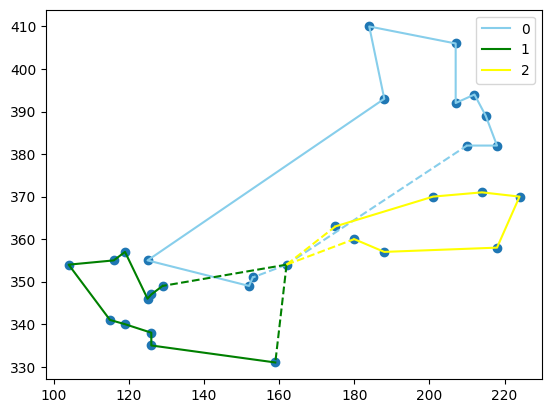

In [325]:
data = vrplib.read_instance(f'{mypath}/' + 'E-n30-k3.vrp')
depot = data['depot'][0]
plot_sol(solution_storage['E-n30-k3.vrp'].routing, data['node_coord'], depot)

Config: n_iters: 5000000 cooling_rate: 0.995 T_init: 100000 max_N: 5


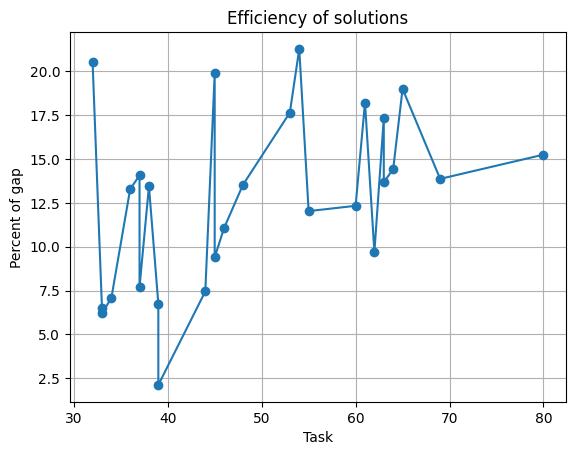

In [200]:
print(f'Config: n_iters: {n_iters} cooling_rate: {cooling_rate} T_init: {T_init} max_N: {max_N}')
plot_optimality_gap()
plot_consumed_time()

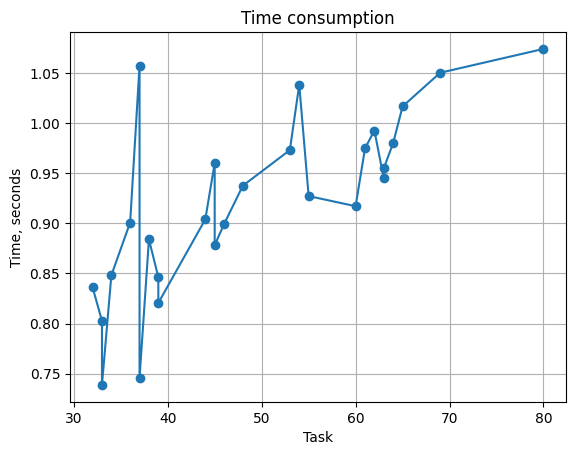

In [151]:
plot_consumed_time()

Config: n_iters: 100000 cooling_rate: 0.9997 T_init: 10000 max_N: 15


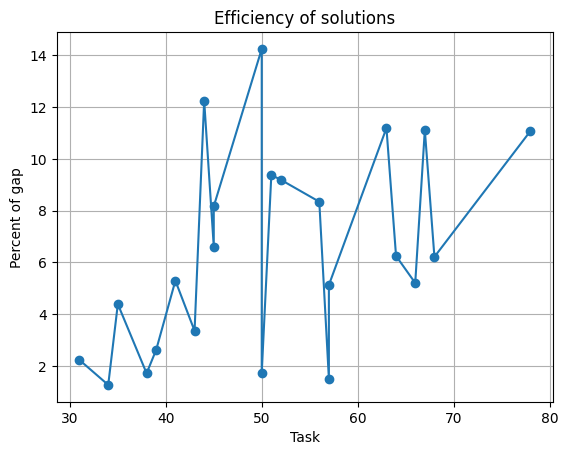

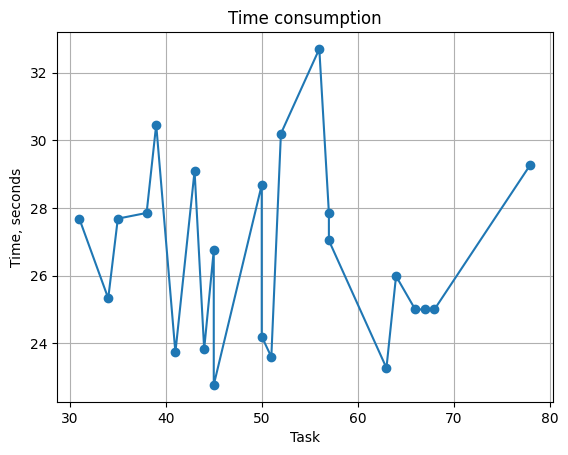

In [119]:
print(f'Config: n_iters: {n_iters} cooling_rate: {cooling_rate} T_init: {T_init} max_N: {max_N}')
plot_optimality_gap()
plot_consumed_time()

Config: n_iters: 50000 cooling_rate: 0.9994 T_init: 3000 max_N: 15


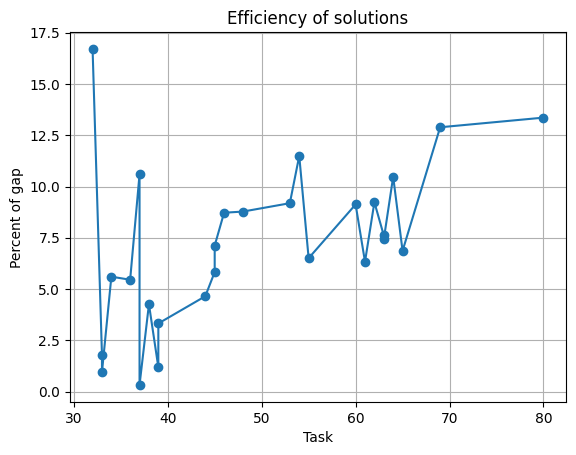

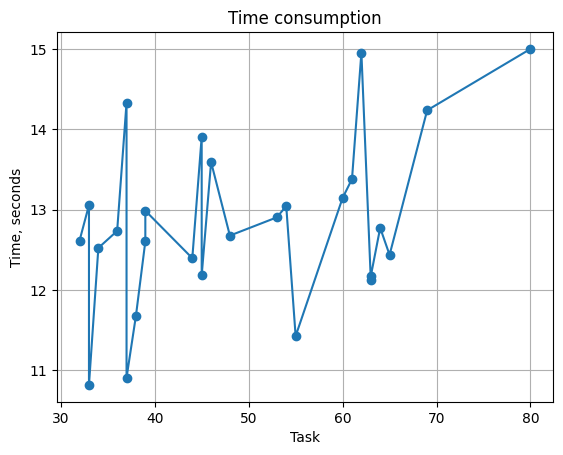

In [89]:
print(f'Config: n_iters: {n_iters} cooling_rate: {cooling_rate} T_init: {T_init} max_N: {max_N}')
plot_optimality_gap()
plot_consumed_time()

Config: n_iters: 50000 cooling_rate: 0.9994 T_init: 10000 max_N: 15


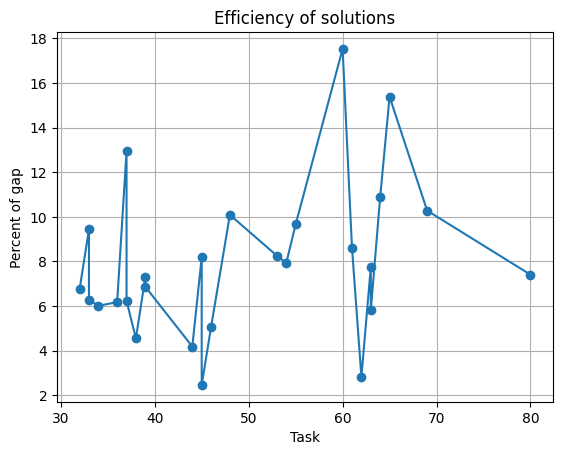

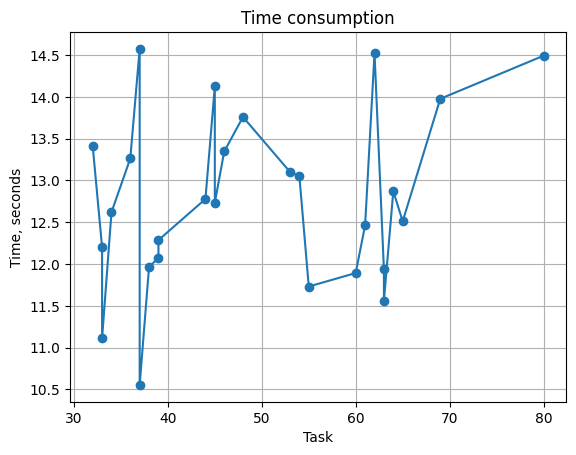

In [78]:
print(f'Config: n_iters: {n_iters} cooling_rate: {cooling_rate} T_init: {T_init} max_N: {max_N}')
plot_optimality_gap()
plot_consumed_time()

Config: n_iters: 3000000 cooling_rate: 0.99999 T_init: 10000 max_N: 15


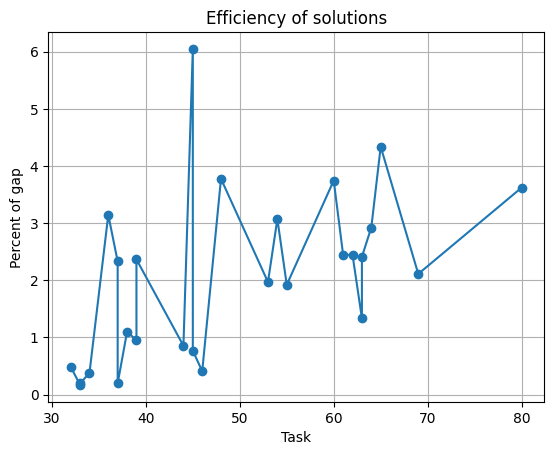

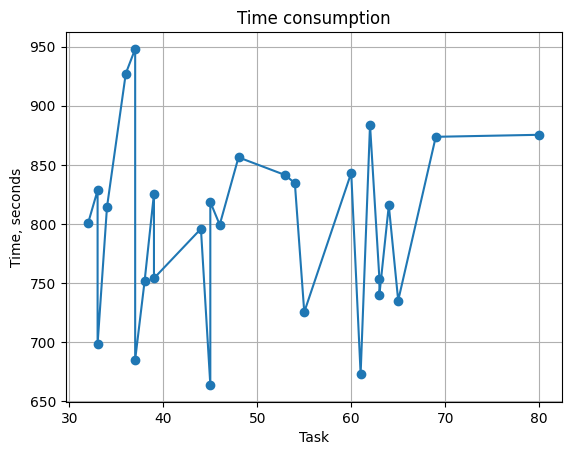

In [57]:
print(f'Config: n_iters: {n_iters} cooling_rate: {cooling_rate} T_init: {T_init} max_N: {max_N}')
plot_optimality_gap()
plot_consumed_time()

Config: n_iters: 30000 cooling_rate: 0.999 T_init: 10000 max_N: 15


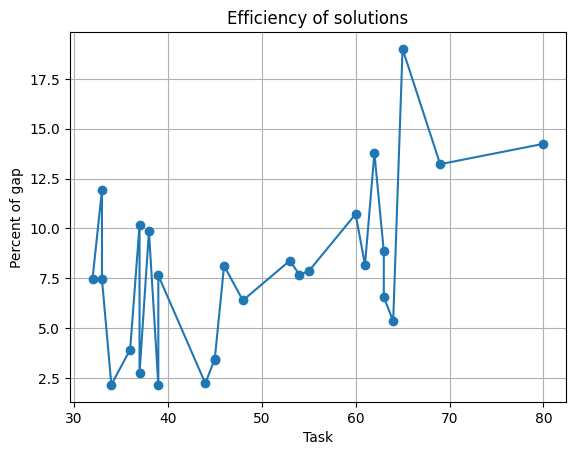

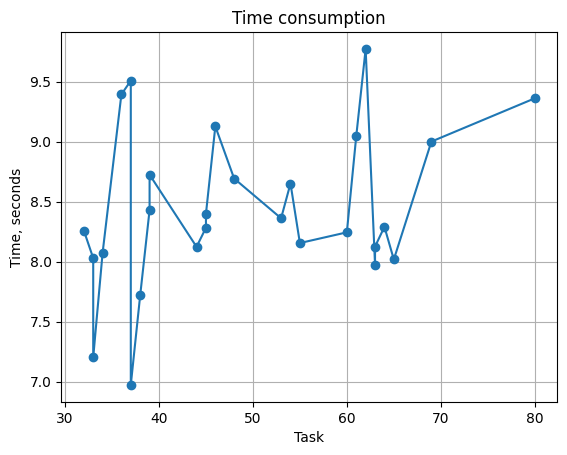

In [49]:
print(f'Config: n_iters: {n_iters} cooling_rate: {cooling_rate} T_init: {T_init} max_N: {max_N}')
plot_optimality_gap()
plot_consumed_time()

In [161]:
for taskname in task_names:
    data = vrplib.read_instance('A/' + taskname)
    best_sol, best_cost = simulated_annealing(data, n_iters, cooling_rate, T_init, max_N)
    print(f'taskname: {taskname} best_cost: {best_cost}')


Initial solution has score: 2097.515424176786


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [14:43<00:00, 3397.39it/s]


Final temperature: 9.356219422584451e-10 metropolis: 1.0
taskname: A-n80-k10.vrp best_cost: 1823.5247787765074 best_sol: [[13, 62, 23, 11, 63, 10], [71, 52, 28, 79, 18, 48, 14], [77, 39, 64, 33, 56, 69, 65, 35, 26, 47, 19, 75, 20, 5], [73, 36, 53, 66, 67, 38, 49], [17, 31, 27, 59, 61, 16, 43, 57], [40, 21, 7, 1], [70, 72, 54, 9, 55, 15, 41, 25, 46, 60], [42, 51, 3, 74, 29, 44, 12], [24, 6, 30, 78, 68, 8, 37, 2, 34], [58, 32, 4, 22, 45, 50, 76]]
Initial solution has score: 1385.2018305426375


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [11:57<00:00, 4178.70it/s]


Final temperature: 9.356219422584451e-10 metropolis: 1.0
taskname: A-n61-k9.vrp best_cost: 1068.7424004523707 best_sol: [[40, 8, 5, 54, 46, 2, 10], [28, 60, 11, 31, 52, 57, 17], [15, 38, 3], [7, 33, 42, 32, 43, 26, 4], [14, 55, 22, 12, 50, 13, 9], [51, 58, 6, 41, 53, 49], [19, 25, 20, 29, 36, 21, 27, 56, 47], [23, 30, 37, 45, 59, 24], [39, 44, 1, 16, 48, 18, 35, 34]]
Initial solution has score: 1952.3437420351172


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [11:59<00:00, 4168.11it/s]


Final temperature: 9.356219422584451e-10 metropolis: 1.0
taskname: A-n63-k9.vrp best_cost: 1654.0962272493337 best_sol: [[16, 3, 41, 38, 43], [26, 25, 36, 48, 60], [7, 10, 39, 23, 52, 37, 6, 12], [61, 42, 9, 31, 46, 1, 18, 4, 47, 62], [19, 54, 29, 30, 2, 34, 20], [11, 33, 44, 15, 56], [28, 22, 50, 58, 32, 55, 53], [21, 40, 14, 57, 51, 35, 17], [5, 45, 27, 59, 24, 8, 49, 13]]
Initial solution has score: 1268.4249613100228


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [12:06<00:00, 4129.19it/s]


Final temperature: 9.356219422584451e-10 metropolis: 1.0
taskname: A-n55-k9.vrp best_cost: 1085.0903510127396 best_sol: [[43, 35, 9, 49, 39, 47], [21, 18, 29, 41, 25], [37, 3, 34, 17, 14], [54, 23, 52, 24, 44, 48, 50], [4, 7, 42, 31, 20, 46, 26], [12, 10, 5, 40, 16, 38, 53, 32], [36, 33, 2, 51, 15, 11], [8, 6, 45, 1], [30, 22, 19, 27, 13, 28]]
Initial solution has score: 780.9241049861805


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [13:15<00:00, 3773.03it/s]


Final temperature: 9.356219422584451e-10 metropolis: 1.0
taskname: A-n33-k5.vrp best_cost: 668.0188932116349 best_sol: [[29, 16, 3, 9, 17, 15], [22, 23, 28, 18, 11], [2, 20, 32, 13, 8, 7, 26, 12], [4, 5, 27, 25, 30, 10], [24, 6, 19, 14, 21, 1, 31]]
Initial solution has score: 899.5485425384115


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [11:18<00:00, 4421.33it/s]


Final temperature: 9.356219422584451e-10 metropolis: 1.0
taskname: A-n33-k6.vrp best_cost: 744.2564222197142 best_sol: [[32, 10, 11, 29, 17, 14], [1, 18, 6, 7, 13], [19, 20, 9, 15, 2, 3, 5], [28, 27, 30, 16, 25], [31, 23, 24, 22, 26, 4, 8], [21, 12]]
Initial solution has score: 878.1312189578987


 67%|██████████████████████████████████████████████████████████████▉                               | 2007355/3000000 [13:12<03:03, 5402.02it/s]/var/folders/38/pfz0dtw13wz77zfk7tbtrhf40000gn/T/ipykernel_39476/516312325.py:43: RuntimeWarning: overflow encountered in exp
  metropolis = np.exp(-diff / t)
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [15:10<00:00, 3293.89it/s]


Final temperature: 9.356219422584451e-10 metropolis: 1.0
taskname: A-n37-k5.vrp best_cost: 689.7744445497661 best_sol: [[21], [1, 23, 24, 9, 11, 27, 8, 25, 30], [15, 34, 36, 32, 28, 26, 35, 18, 31, 29], [7, 4, 33, 5, 6, 10, 13, 22], [16, 12, 2, 19, 20, 14, 17, 3]]
Initial solution has score: 1225.074190178582


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [10:50<00:00, 4608.52it/s]


Final temperature: 9.356219422584451e-10 metropolis: 1.0
taskname: A-n37-k6.vrp best_cost: 952.1820288542464 best_sol: [[13, 30, 15, 32, 27], [24, 29, 36, 6, 14], [16, 25, 35, 7], [31, 19, 9, 21, 26, 4], [20, 33, 2, 28, 23, 22, 12, 11, 10], [18, 17, 34, 1, 3, 5, 8]]
Initial solution has score: 1148.207734562575


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [13:03<00:00, 3827.45it/s]


Final temperature: 9.356219422584451e-10 metropolis: 1.0
taskname: A-n46-k7.vrp best_cost: 947.0850931988484 best_sol: [[17, 9], [36, 5, 22, 44, 25, 18, 35], [32, 3, 39, 7, 10, 12, 11], [38, 4, 30, 2, 37], [23, 14, 6, 43, 26, 13, 45], [8, 33, 42, 24, 16, 15, 19], [28, 41, 20, 27, 1, 40, 34, 31, 29, 21]]
Initial solution has score: 1430.9791994033963


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [13:14<00:00, 3774.19it/s]


Final temperature: 9.356219422584451e-10 metropolis: 1.0
taskname: A-n54-k7.vrp best_cost: 1197.466693615829 best_sol: [[52, 32, 27, 37, 12, 2, 14, 6], [34, 41, 24, 48, 40, 8, 19, 31, 11], [20, 49, 36, 45, 26, 21, 33, 9, 38], [23, 29, 1, 17, 10, 15, 35], [43, 4, 28, 7, 39, 50, 5, 18], [13, 53, 22, 3, 44], [30, 25, 47, 51, 42, 46, 16]]
Initial solution has score: 1161.403412642236


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [12:40<00:00, 3943.54it/s]


Final temperature: 9.356219422584451e-10 metropolis: 1.0
taskname: A-n44-k6.vrp best_cost: 938.8396140338012 best_sol: [[39, 30, 23, 40, 43, 29], [7, 5, 21, 32, 42, 37, 10, 33, 24], [4, 17, 12, 3, 25, 6], [8, 15, 28, 27, 19, 31], [2, 41, 14, 13, 38, 9, 36, 22], [34, 26, 11, 16, 20, 18, 35, 1]]
Initial solution has score: 905.137379911933


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [12:49<00:00, 3899.39it/s]


Final temperature: 9.356219422584451e-10 metropolis: 1.0
taskname: A-n39-k6.vrp best_cost: 853.1709704786666 best_sol: [[26, 5, 28, 9, 12, 38, 37, 31, 35, 25, 14], [11, 36, 17, 23, 1, 6], [13, 15], [30, 20, 7, 8, 4, 19, 33, 2], [21, 18, 22, 34, 16, 10, 27, 32], [24, 3, 29]]
Initial solution has score: 1309.7873042403085


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [12:56<00:00, 3862.75it/s]


Final temperature: 9.356219422584451e-10 metropolis: 1.0
taskname: A-n48-k7.vrp best_cost: 1078.8412506196055 best_sol: [[18, 35, 44], [16, 28, 29, 21, 30, 13, 46, 33], [45, 27, 15, 42, 11, 4, 24, 9, 34], [14, 41, 2, 10, 47, 17], [40, 7, 8, 39, 26, 20, 3, 37], [32, 36, 38, 19, 25, 22, 6], [23, 43, 31, 1, 5, 12]]
Initial solution has score: 1009.5328161356508


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [12:45<00:00, 3919.95it/s]


Final temperature: 9.356219422584451e-10 metropolis: 1.0
taskname: A-n39-k5.vrp best_cost: 837.3656840222804 best_sol: [[21, 30, 13, 28, 27, 36, 6], [14, 12, 9, 4], [11, 26, 34, 37, 35, 22, 3, 7, 16], [33, 31, 1, 10, 32, 2, 24, 17, 8], [19, 25, 23, 20, 29, 5, 15, 38, 18]]
Initial solution has score: 1457.5131523990785


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [14:06<00:00, 3544.54it/s]


Final temperature: 9.356219422584451e-10 metropolis: 1.0
taskname: A-n69-k9.vrp best_cost: 1185.6726219055222 best_sol: [[31, 18, 53, 2, 33, 49, 9, 30, 6, 15, 3, 51], [7, 67, 21, 61, 64], [28, 57, 42, 25, 11, 63, 46, 5, 26], [19, 23, 66, 12, 22], [43, 56, 39, 8, 59, 68, 58], [40, 38, 41, 20, 45, 35, 13, 44], [34, 14, 47, 4, 60, 55, 65, 27], [24, 29, 62, 16, 50, 52], [54, 37, 17, 32, 10, 36, 1, 48]]
Initial solution has score: 1397.087681314714


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [11:54<00:00, 4197.02it/s]


Final temperature: 9.356219422584451e-10 metropolis: 1.0
taskname: A-n65-k9.vrp best_cost: 1203.1380326200285 best_sol: [[55, 25, 56, 44, 59], [5, 32, 20, 58, 40, 53], [47, 34, 31, 26, 6, 64, 46], [29, 18, 33, 1, 23, 57, 48, 54, 11], [49, 4, 3, 36, 35, 37, 30], [21, 19, 52, 8, 10, 24, 13, 12], [17, 51, 39, 7, 63, 28, 62], [43, 27, 14, 9, 22, 15], [60, 50, 16, 41, 2, 38, 42, 61, 45]]
Initial solution has score: 1591.2713167442228


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [13:14<00:00, 3774.04it/s]


Final temperature: 9.356219422584451e-10 metropolis: 1.0
taskname: A-n60-k9.vrp best_cost: 1358.7466262027874 best_sol: [[15, 43, 56, 12, 51, 9, 32], [35, 55, 50, 39, 26, 8, 13], [16, 20, 3, 11, 40, 46, 25], [2, 1, 48, 22, 36, 31], [41, 33, 38, 59, 52, 18], [6, 28, 44, 49, 30, 53, 21, 4], [7, 29, 37, 57, 17, 27, 19], [10, 54, 5, 45, 42], [14, 47, 23, 58, 24, 34]]
Initial solution has score: 1587.2823879735438


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [12:06<00:00, 4128.17it/s]


Final temperature: 9.356219422584451e-10 metropolis: 1.0
taskname: A-n63-k10.vrp best_cost: 1322.854675792344 best_sol: [[28, 57, 32, 34, 11, 47, 51, 31], [48, 30, 43, 52], [50, 44, 58, 22, 55, 33], [49, 53, 6, 27, 35, 8], [21, 61, 60, 37, 16, 54], [36, 38, 4, 26, 13, 20], [17, 56, 29, 40, 25], [5, 45, 39, 1, 41, 2, 9, 12, 14], [62, 24, 46, 23, 7], [15, 18, 3, 42, 19, 10, 59]]
Initial solution has score: 1313.7499162447195


  4%|███▋                                                                                           | 115163/3000000 [00:54<22:24, 2145.32it/s]

Initial solution has score: 978.631301323884


 20%|██████████████████▊                                                                           | 1000314/5000000 [08:11<28:01, 2378.07it/s]

Iter #999999 best_cost: 975.4010456462452


 40%|█████████████████████████████████████▌                                                        | 2000527/5000000 [13:42<16:29, 3031.52it/s]

Iter #1999999 best_cost: 793.441953376857


 51%|████████████████████████████████████████████████▍                                             | 2573248/5000000 [16:05<09:22, 4314.52it/s]/var/folders/38/pfz0dtw13wz77zfk7tbtrhf40000gn/T/ipykernel_39476/949378687.py:44: RuntimeWarning: overflow encountered in exp
  metropolis = np.exp(-diff / t)
 60%|████████████████████████████████████████████████████████▍                                     | 3001404/5000000 [17:35<06:13, 5355.39it/s]

Iter #2999999 best_cost: 787.8086948893183


 80%|███████████████████████████████████████████████████████████████████████████▏                  | 4002008/5000000 [20:04<01:49, 9112.36it/s]

Iter #3999999 best_cost: 787.8086948893183


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 5000000/5000000 [21:15<00:00, 3920.37it/s]


Iter #4999999 best_cost: 787.8086948893183
Final temperature: 9.356780819618716e-10 metropolis: 1.0
Storage: defaultdict(<class 'int'>, {0: 6607974, 1: 13331404, 2: 6341369})


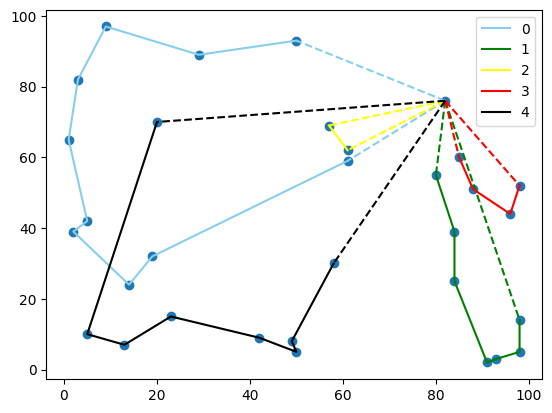

([[20, 5, 25, 10, 15, 22, 9, 8, 18, 14],
  [26, 7, 13, 17, 19, 31, 21],
  [27, 24],
  [30, 16, 1, 12],
  [6, 3, 2, 23, 28, 4, 11, 29]],
 787.8086948893183)

In [115]:
best_sol, best_cost = simulated_annealing(data, n_iters, cooling_rate, T_init, max_N)
plot_sol(best_sol, data['node_coord'], data['depot'][0])
# print(f'n_iters: {n_iters}, cooling_rate: {cooling_rate}, T_init: {T_init}, max_N: {max_N}')
best_sol, best_cost

In [ ]:
data = vrplib.read_instance('A-n32-k5.vrp')

best_sol, best_cost = simulated_annealing(objective, data, n_iterations=10000000, 
                                                               cooling_rate=0.999995, 
                                                               T_init=1e12, 
                                                               max_N=10)
plot_sol(best_sol, data['node_coord'], data['depot'][0])
best_sol, best_cost

([[30, 16, 1, 12],
  [24, 27],
  [18, 8, 9, 22, 15, 29, 10, 25, 5, 20],
  [6, 3, 2, 23, 4, 11, 28, 14],
  [26, 7, 13, 17, 19, 31, 21]],
 787.0818888551105)

In [ ]:
data = vrplib.read_instance('A-n32-k5.vrp')

best_sol, best_cost = simulated_annealing(objective, data, n_iterations=5000000, 
                                                               cooling_rate=0.999992, 
                                                               T_init=1e12, 
                                                               max_N=5)
plot_sol(best_sol, data['node_coord'], data['depot'][0])
best_sol, best_cost

([[26, 7, 13, 17, 19, 31, 21],
  [30, 16, 1, 12],
  [14, 28, 11, 4, 23, 2, 3, 6],
  [20, 29, 18, 8, 9, 22, 15, 10, 25, 5],
  [24, 27]],
 795.9083672914132)

In [ ]:
# data = vrplib.read_instance('A-n32-k5.vrp')

# best_sol, best_cost = simulated_annealing(objective, data, n_iterations=30000000, 
#                                                                cooling_rate=0.9999983, 
#                                                                T_init=1e12, 
#                                                                max_N=2)
# plot_sol(best_sol, data['node_coord'], data['depot'][0])
# best_sol, best_cost

# ([[26, 13, 17, 19, 31, 21, 7],
#   [30, 16, 1, 12],
#   [20, 29, 8, 9, 22, 15, 10, 25, 5],
#   [24, 27],
#   [14, 18, 11, 4, 28, 23, 2, 3, 6]],
#  799.1494988333296)

In [63]:
data = vrplib.read_instance('A-n32-k5.vrp')

for i in range(1, 15):
    best_sol, best_cost = simulated_annealing(objective, data, n_iterations=1000000, 
                                                               cooling_rate=0.99995, 
                                                               T_init=1e12, 
                                                               max_N=i)
    # plot_sol(best_sol, data['node_coord'], data['depot'][0])
    print(i, best_cost, best_sol)
# идея: if rearange лучше, то делать

Initial solution has score: 978.631301323884


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:50<00:00, 19914.18it/s]


Final temperature: 1.9263403366054433e-10 metropolis: 0.0
1 858.4344987309827 [[7, 2, 23, 4, 11, 28, 8, 18], [20, 29, 15, 22, 9, 10, 25, 5], [13, 21, 31, 19, 17, 3, 6], [30, 16, 1, 12, 26], [24, 14, 27]]
Initial solution has score: 978.631301323884


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:51<00:00, 19438.00it/s]


Final temperature: 1.9263403366054433e-10 metropolis: 1.0
2 847.6409887286667 [[20, 29, 15, 22, 9, 10, 25, 5], [3, 2, 23, 4, 11, 28, 8, 18], [26, 6, 17, 19, 31, 21, 13], [30, 12, 7, 1, 16], [24, 14, 27]]
Initial solution has score: 978.631301323884


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:52<00:00, 19028.50it/s]


Final temperature: 1.9263403366054433e-10 metropolis: 1.0
3 884.2483222174588 [[26, 6, 3, 4, 11, 9, 22, 27], [30, 7, 2, 23, 28, 8, 18, 14], [24, 29, 15, 10, 25, 5, 20], [13, 19, 17, 31, 21], [16, 1, 12]]
Initial solution has score: 978.631301323884


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:52<00:00, 19086.00it/s]


Final temperature: 1.9263403366054433e-10 metropolis: 1.0
4 881.6912734234292 [[26, 6, 23, 4, 11, 9, 22, 27], [30, 7, 3, 2, 28, 8, 18, 14], [24, 29, 15, 10, 25, 5, 20], [13, 19, 17, 31, 21], [16, 1, 12]]
Initial solution has score: 978.631301323884


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:52<00:00, 19085.95it/s]


Final temperature: 1.9263403366054433e-10 metropolis: 0.0
5 877.4590037113306 [[6, 18, 8, 9, 15, 10, 25, 5], [29, 22, 11, 4, 28, 23, 2, 3], [26, 13, 19, 17, 31, 21, 7], [30, 14, 20, 27, 24], [16, 1, 12]]
Initial solution has score: 978.631301323884


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:52<00:00, 18952.47it/s]


Final temperature: 1.9263403366054433e-10 metropolis: 1.0
6 908.413757246543 [[26, 7, 13, 2, 23, 3, 14, 24], [20, 5, 25, 10, 15, 22, 18, 6], [27, 8, 28, 4, 11, 9, 29], [1, 31, 17, 19, 21], [30, 12, 16]]
Initial solution has score: 978.631301323884


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:53<00:00, 18865.52it/s]


Final temperature: 1.9263403366054433e-10 metropolis: 0.0
7 847.6409887286665 [[3, 2, 23, 4, 11, 28, 8, 18], [20, 29, 15, 22, 9, 10, 25, 5], [26, 6, 17, 19, 31, 21, 13], [30, 12, 7, 1, 16], [24, 14, 27]]
Initial solution has score: 978.631301323884


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:54<00:00, 18393.58it/s]


Final temperature: 1.9263403366054433e-10 metropolis: 1.0
8 904.5764442844546 [[30, 20, 5, 25, 10, 15, 29, 14], [26, 7, 3, 2, 23, 8, 18, 24], [27, 22, 9, 11, 4, 28, 6], [13, 19, 17, 31, 21], [16, 1, 12]]
Initial solution has score: 978.631301323884


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:55<00:00, 18075.50it/s]


Final temperature: 1.9263403366054433e-10 metropolis: 1.0
9 851.6328887345527 [[27, 22, 9, 11, 4, 28, 8, 18], [26, 7, 13, 2, 23, 3, 6, 14], [24, 29, 15, 10, 25, 5, 20], [1, 31, 17, 19, 21], [30, 12, 16]]
Initial solution has score: 978.631301323884


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:55<00:00, 17966.95it/s]


Final temperature: 1.9263403366054433e-10 metropolis: 1.0
10 918.0292897662716 [[26, 13, 21, 31, 19, 17, 6, 14], [24, 18, 28, 4, 11, 9, 22, 29], [3, 2, 23, 8, 15, 10, 25], [30, 12, 7, 1, 16], [27, 5, 20]]
Initial solution has score: 978.631301323884


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:56<00:00, 17675.57it/s]


Final temperature: 1.9263403366054433e-10 metropolis: 0.0
11 866.5653371984131 [[24, 22, 9, 11, 4, 28, 8, 18], [27, 20, 5, 25, 10, 15, 29, 14], [30, 7, 3, 23, 2, 6, 26], [13, 19, 17, 31, 21], [16, 1, 12]]
Initial solution has score: 978.631301323884


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:56<00:00, 17565.87it/s]


Final temperature: 1.9263403366054433e-10 metropolis: 0.0
12 869.6903965378982 [[26, 6, 3, 17, 19, 31, 21, 13], [20, 29, 15, 22, 9, 10, 25, 5], [18, 8, 28, 11, 4, 23, 2], [30, 12, 7, 1, 16], [24, 14, 27]]
Initial solution has score: 978.631301323884


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:57<00:00, 17304.94it/s]


Final temperature: 1.9263403366054433e-10 metropolis: 0.0
13 895.8441357416215 [[26, 21, 31, 19, 17, 23, 3, 6], [20, 18, 8, 11, 4, 28, 2, 13], [5, 25, 10, 9, 22, 15, 29], [30, 12, 7, 1, 16], [24, 14, 27]]
Initial solution has score: 978.631301323884


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:58<00:00, 16978.50it/s]

Final temperature: 1.9263403366054433e-10 metropolis: 1.0
14 866.5653371984131 [[27, 20, 5, 25, 10, 15, 29, 14], [24, 22, 9, 11, 4, 28, 8, 18], [30, 7, 3, 23, 2, 6, 26], [13, 19, 17, 31, 21], [16, 1, 12]]


In [105]:
# 500000, 0.9999, 1e8
# ([[29, 8, 28, 4, 11, 23, 3, 2],
#   [20, 5, 25, 10, 15, 22, 9, 18],
#   [26, 13, 21, 31, 19, 17, 6],
#   [30, 16, 12, 1, 7],
#   [24, 14, 27]],
#  843.1607395003922)


In [187]:
t = 1e12
for i in range(1000000):
    t *= 0.99995
print(t)

1.9263403366054433e-10


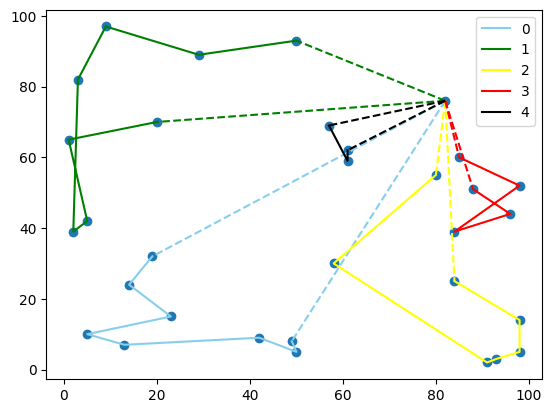

838.9350221232474

In [69]:
sol = [[3, 2, 23, 4, 11, 28, 8, 18], [29, 15, 22, 9, 10, 25, 5, 20], [26, 6, 17, 19, 31, 21, 13], [30, 12, 7, 1, 16], [24, 14, 27]]
plot_sol(sol, data['node_coord'], data['depot'][0])
objective(sol, distances, depot)

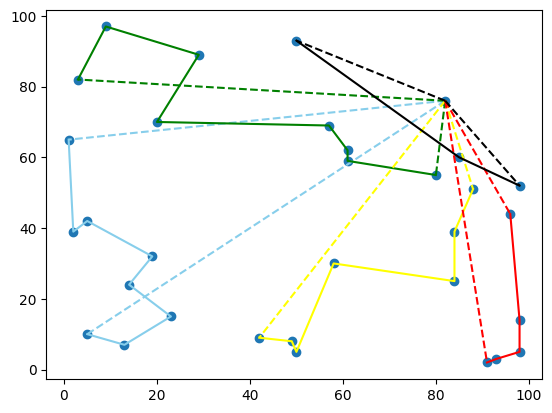

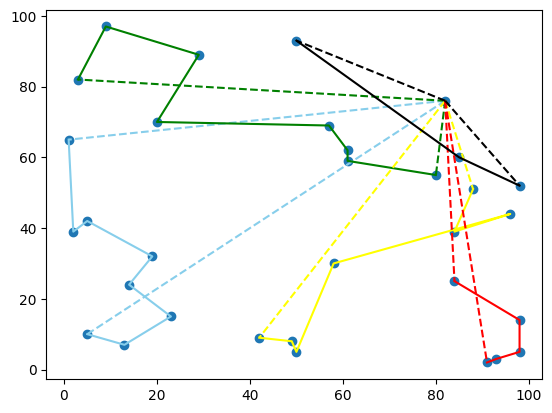

In [349]:
# Read initial data
n = data['dimension']
Q = data['capacity']
m = int(data['comment'].split(', ')[1].split()[-1])
distances = data['edge_weight']
demands = data['demand']
depot = data['depot'][0]

# Generate the initial solution
heur = sequential_heuristic(n, Q, m, distances, demands, depot)
plot_sol(heur, coords, depot)
plt.show()


candidate = get_candidate3(heur, 1, demands, Q, distances)
# for i in range(5):
#     candidate = get_candidate3(candidate, 1, demands, Q, distances)
    
plot_sol(candidate, coords, depot)
plt.show()

Cost: 978.631301323884


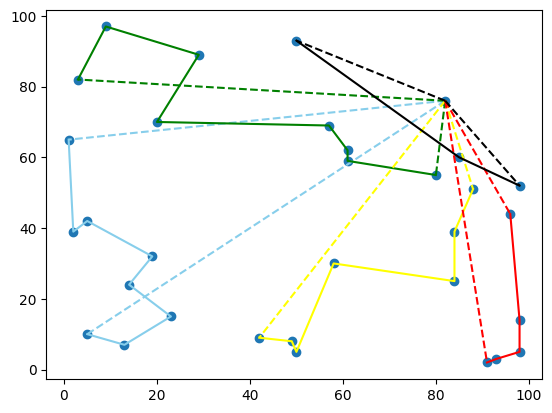

In [162]:
data = vrplib.read_instance('A-n32-k5.vrp')
plt.scatter(data['node_coord'].T[0], data['node_coord'].T[1])

n = data['dimension']
Q = data['capacity']
m = int(data['comment'].split(', ')[1].split()[-1])
distances = data['edge_weight']
demands = data['demand']
depot = data['depot'][0]
coords = data['node_coord']

sol = sequential_heuristic(n, Q, m, distances, demands, depot)

xd, yd = coords[depot]
colors = ['skyblue', 'green', 'yellow', 'red', 'black']
for i, route in enumerate(sol):
    c = coords[route].T
    plt.plot(c[0], c[1], color=colors[i])
    plt.plot([xd, c[0][0]], [yd, c[1][0]], '--', color=colors[i])
    plt.plot([xd, c[0][-1]], [yd, c[1][-1]], '--', color=colors[i])

print(f'Cost: {objective(sol, distances, depot)}')

In [ ]:
data = vrplib.read_instance('A-n32-k5.vrp')

best_sol, best_cost = simulated_annealing(objective, data, n_iterations=10000000, 
                                                               cooling_rate=0.999996, 
                                                               T_init=1e12, 
                                                               max_N=3)
plot_sol(best_sol, data['node_coord'], data['depot'][0])
best_sol, best_cost

([[6, 18, 9, 15, 10, 25, 5, 20],
  [14, 3, 2, 23, 28, 4, 11, 8, 22, 29],
  [27, 24],
  [30, 16, 1, 12],
  [26, 7, 13, 17, 19, 31, 21]],
 800.4118864001788)

In [74]:
def get_candidate3(current_solution, N, demands, Q, distances):
    # Find the most closest routes
    # Swap two the most closest users
    
    def routes_distance(r1, r2):
        dist = 0
        for a in r1:
            for b in r2:
                dist += distances[a][b]
        return dist / (len(r1) * len(r2))
    
    n = len(current_solution)
    
    r1_idx, r2_idx = -1, -1
    best_dist = float('inf')
    for i in range(n):
        for j in range(i + 1, n):
            cur_dist = routes_distance(current_solution[i], current_solution[j])
            if cur_dist < best_dist:
                best_dist = cur_dist
                r1_idx, r2_idx = i, j
    
    u1, u1_idx = -1, -1
    route1 = current_solution[r1_idx]
    u2, u2_idx = -1, -1
    route2 = current_solution[r2_idx]
    
    u1 = np.random.choice(route1)
    u1_idx = route1.index(u1)

    u2 = np.random.choice(route2)
    u2_idx = route2.index(u2)
    
#     best_dist = float('inf')
#     for i in range(len(route1)):
#         ui = route1[i]
#         for j in range(len(route2)):
#             uj = route2[j]
#             if distances[ui][uj] < best_dist:
#                 best_dist = distances[ui][uj]
#                 u1, u1_idx = ui, i
#                 u2, u2_idx = uj, j
    
    # Swap
    new_solution = current_solution.copy()
    new_solution[r1_idx].pop(u1_idx)
    new_solution[r1_idx].insert(u1_idx, u2)
    
    new_solution[r2_idx].pop(u2_idx)
    new_solution[r2_idx].insert(u2_idx, u1)
    
    # If incorrect, swap back
    if not is_valid(new_solution[r1_idx], demands, Q) or not is_valid(new_solution[r2_idx], demands, Q):
        new_solution[r1_idx].pop(u1_idx)
        new_solution[r1_idx].insert(u1_idx, u1)
        
        new_solution[r2_idx].pop(u2_idx)
        new_solution[r2_idx].insert(u2_idx, u2)
    return new_solution
    

In [73]:
def get_candidate2(n, Q, m, distances, demands, depot):
    def get_faraway_unvuser():
        related = [u for u in range(n) if not visited[u]]
        if len(related) > 0:
            return np.random.choice(related)
        return -1
        
    def get_closest_unvuser(u_init: int):
        cu = -1
        min_dist = float('inf')
        
        for u in range(n):
            if not visited[u] and distances[u_init][u] < min_dist:
                min_dist = distances[u_init][u]
                cu = u
        return cu
        
    
    visited = np.zeros(n, dtype=bool)
    visited[depot] = True
    
    # Solution
    x = []
    
    while not all(visited):
        cur_route = []
        
        # Initialize new route by faraway unvisited user
        cur_Q = 0
        init_user = get_faraway_unvuser()
        
        # Visit
        cur_Q += demands[init_user]
        cur_route.append(init_user)
        visited[init_user] = True
        
        while True:
            # Get the closest unvisited
            last_user = cur_route[-1]
            closest_user = get_closest_unvuser(last_user)
            
            # No user found
            if closest_user == -1:
                break
            
            # If capacity exceeds
            if cur_Q + demands[closest_user] > Q:
                break
            
            # Visit
            cur_Q += demands[closest_user]
            cur_route.append(closest_user)
            visited[closest_user] = True
        
        # Add current route
        x.append(cur_route)
        
        if len(route) > m:
            raise AssertionError('Number of cars was exceeded')
    return x

In [ ]:
def get_candidate(current_solution: list, N: int, demands, Q):
    near_solution = current_solution.copy()
    success_flag = False
    for i in range(N):
        # Swap users within a route
#         for route in near_solution:
#             if len(route) < 2:
#                 continue
            
#             i, j = np.random.choice(len(route), size=2, replace=False)
#             route[i], route[j] = route[j], route[i]
            
#             if not is_valid(route, demands, Q):
#                 route[i], route[j] = route[j], route[i]
#             else:
#                 success_flag = True
#                 break
        
        # Swap users between two random routes
        i, j = np.random.choice(len(near_solution), size=2, replace=False)
        
        if len(near_solution[i]) < 2 or len(near_solution[j]) < 2:
            continue
        
        from_idx = np.random.randint(len(near_solution[i]))
        to_idx = np.random.randint(len(near_solution[j]))
        
        swap_user = near_solution[i].pop(from_idx)
        near_solution[j].insert(to_idx, swap_user)
        
        if not is_valid(near_solution[j], demands, Q):
            near_solution[j].pop(to_idx)
            near_solution[i].insert(from_idx, swap_user)
        else:
            success_flag = True
    return near_solution, success_flag

In [ ]:
# data = vrplib.read_instance('A-n32-k5.vrp')

# best_sol, best_cost = simulated_annealing(objective, data, n_iterations=2000000, 
#                                                                cooling_rate=0.99997, 
#                                                                T_init=1e12, 
#                                                                max_N=1)
# plot_sol(best_sol, data['node_coord'], data['depot'][0])
# best_sol, best_cost
# ([[24, 22, 9, 11, 4, 28, 8, 18],
#   [20, 5, 25, 10, 15, 29, 27],
#   [30, 16],
#   [7, 13, 17, 19, 31, 21, 26],
#   [14, 6, 23, 3, 2, 1, 12]],
#  832.7751301867446)

In [ ]:
    # Rearange users in r1 and r2
    # method1
#     for idx in [r1_idx, r2_idx]:
#         new_route = []
#         route = near_solution[idx]
#         last_u = depot
        
#         while len(route) > 0:
#             best_u = get_nearest(route, last_u, distances)
#             new_route.append(best_u)
#             route.remove(best_u)
#             last_u = best_u

#         near_solution[idx] = new_route